## Eluvio Coding Challenge: DS/ML Option

Dataset:
https://drive.google.com/file/d/15X00ZWBjla7qGOIW33j8865QdF89IyAk/view?usp=sharing\

- This dataset appears to be data from a social media website containing posts just from the "world news" category. Many posts are flagged as being "NFSW"/"NSFL", which leads me to suspect that this data was obtained from the Reddit platform, but it could be from a similar social media app as well.

- In this notebook we will analyze all the features in this dataset, perform some initial data wrangling, and extract some additional features with which to further analyze and use in the modeling process in the next notebook.

## EDA

In [ ]:
!pip install textstat

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from textstat import flesch_reading_ease,flesch_kincaid_grade
from datetime import datetime

from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/Eluvio_Challenge/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv('Eluvio_DS_Challenge.csv')

In [ ]:
(print('File size:',round(os.stat('Eluvio_DS_Challenge.csv').st_size /1000/1000,2),'MBs'))
print(f"This dataset contains {data.shape[0]} rows and {data.shape[1]} columns.")

File size: 82.16 MBs
This dataset contains 509236 rows and 8 columns.


In [ ]:
data.head()

,time_created,date_created,up_votes,down_votes,title,over_18,author,category
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509236 entries, 0 to 509235
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   time_created  509236 non-null  int64 
 1   date_created  509236 non-null  object
 2   up_votes      509236 non-null  int64 
 3   down_votes    509236 non-null  int64 
 4   title         509236 non-null  object
 5   over_18       509236 non-null  bool  
 6   author        509236 non-null  object
 7   category      509236 non-null  object
dtypes: bool(1), int64(3), object(4)
memory usage: 27.7+ MB


In [ ]:
# inspecting "down_votes" column. This column is composed entirely of null values.

print(data.down_votes.value_counts())
data.down_votes.describe()

0    509236
Name: down_votes, dtype: int64


count    509236.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: down_votes, dtype: float64

In [ ]:
# inspecting "category" column. This column is composed entirely of 'worldnews' values.

print(data.category.unique())
data.category.value_counts()

['worldnews']


worldnews    509236
Name: category, dtype: int64

### Dropping Null Value Columns
The down_votes column is has entirely 0 down_votes, thus we will drop this column as it contains no unique information.
The "category column" has only one entry, "world news", thus we will drop this column

In [ ]:
data.drop(columns=['down_votes'],inplace=True)
data.drop(columns=['category'],inplace=True)

### Wrangling Datetime Variables 
Additionally we wil extract other date/time variables useful in later data analysis

In [ ]:

# converting "time_created" timestamp to datetime object
data.time_created = data.time_created.apply(lambda x: datetime.fromtimestamp(x))

# dropping "date_created" as "time_created" contains a more granular timestamp
data.drop(columns=['date_created'],inplace=True)

# creating "clock_time", "hour","day_of_week", and "month" features
data['clock_time'] = data.time_created.apply(lambda x: x.time())
data['hour'] = data.time_created.apply(lambda x: x.hour)
data['day_of_week'] = data.time_created.apply(lambda x: x.dayofweek)
data['month'] = data.time_created.apply(lambda x: x.month)
data['year'] = data.time_created.dt.year

#creating "hour_period" feature by binning hours into groups
b = [0,4,8,12,16,20,24]
l = ['Late_Night', 'Early_Morning','Morning','Noon','Evening','Night']
data['hour_period'] = pd.cut(data['hour'], bins=b, labels=l, include_lowest=True)

#creating "season" feature by months into groups
b = [0,4,7,10,13]
l = ['Q1', 'Q2','Q3','Q4']
data['season'] = pd.cut(data['month'], bins=b, labels=l, include_lowest=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509236 entries, 0 to 509235
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   time_created  509236 non-null  datetime64[ns]
 1   up_votes      509236 non-null  int64         
 2   title         509236 non-null  object        
 3   over_18       509236 non-null  bool          
 4   author        509236 non-null  object        
 5   clock_time    509236 non-null  object        
 6   hour          509236 non-null  int64         
 7   day_of_week   509236 non-null  int64         
 8   month         509236 non-null  int64         
 9   year          509236 non-null  int64         
 10  hour_period   509236 non-null  category      
 11  season        509236 non-null  category      
dtypes: bool(1), category(2), datetime64[ns](1), int64(5), object(3)
memory usage: 36.4+ MB


In [ ]:
data.describe()

,up_votes,hour,day_of_week,month,year
count,509236.000000,509236.000000,509236.000000,509236.000000,509236.000000
mean,112.236283,13.106742,2.716483,6.457293,2013.242734
std,541.694675,6.123779,1.917320,3.395653,2.237750
min,0.000000,0.000000,0.000000,1.000000,2008.000000
25%,1.000000,9.000000,1.000000,3.000000,2012.000000
50%,5.000000,14.000000,3.000000,6.000000,2014.000000
75%,16.000000,18.000000,4.000000,9.000000,2015.000000
max,21253.000000,23.000000,6.000000,12.000000,2016.000000


## Initial EDA: Analysis on Column Features
### Analyzing Author Column

In [ ]:
print("Number of unique authors:", data.author.nunique())

Number of unique authors: 85838


In [ ]:
print("Top ten authors by most posts:")
data.author.value_counts().head(10)

Top ten authors by most posts:


davidreiss666    8897
anutensil        5730
DoremusJessup    5037
maxwellhill      4023
igeldard         4013
readerseven      3170
twolf1           2923
madam1           2658
nimobo           2564
madazzahatter    2503
Name: author, dtype: int64

Note in the cell below, the median number of posts is 1 post. The 75th percentile still only posts 2 posts. There are a signifcant number of outliers in this dataset with the maximum number of posts by one user being 8,897.

In [ ]:
print("Number of Posts Per Author:\n")
data.author.value_counts().describe()

Number of Posts Per Author:



count    85838.000000
mean         5.932524
std         62.282937
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max       8897.000000
Name: author, dtype: float64

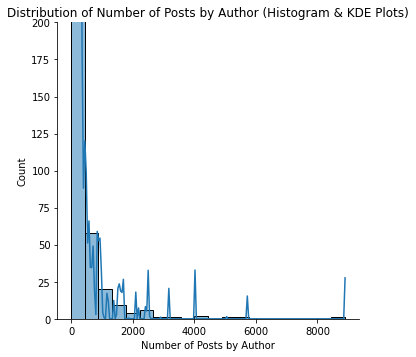

In [ ]:
sns.displot(data.author.value_counts(), bins=20, kde=True)
plt.ylim((0,200))
plt.xlabel("Number of Posts by Author")
plt.title("Distribution of Number of Posts by Author (Histogram & KDE Plots)")
plt.show()

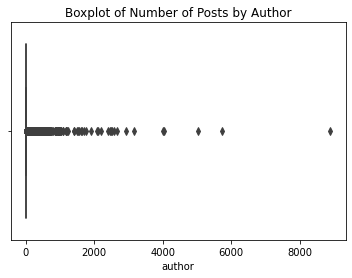

In [ ]:
sns.boxplot(x=data.author.value_counts())
plt.title("Boxplot of Number of Posts by Author")
plt.show()

## Analysis of "over_18" Column
In the cells below we can see almost the entirely posts have "over_18"==False. In the graph the number of "over_18" does not even register. On further analysis of the contents of the "title" of posts that have "over_18"==True, we can see that this is in fact a content rating, indicating that these posts contain "NSFW"/"NSFL" content.

In [ ]:
data.over_18.value_counts()

False    508916
True        320
Name: over_18, dtype: int64

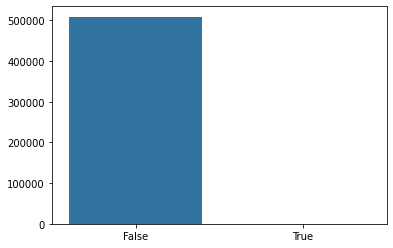

In [ ]:
sns.barplot(x=data.over_18.value_counts().index, y=data.over_18.value_counts().values)
plt.show()

In [ ]:
data[data.over_18 ==True].title.head(20).values

array(['Pics from the Tibetan protests - more graphic than Wikileaks [nsfw? graphic]',
       'MI5 linked to Max Mosley’s Nazi-style, sadomasochistic sex orgy. Mosley’s father led the British Union of Fascists in the 30s and 40s. His mother was a great admirer of Adolf Hitler.[NSFW]',
       'Tabloid Horrifies Germany: Poland s Yellow Press Turns Blood Red (if you follow the link to the gallery: 4th picture is NSFW in the US)',
       'Love Parade Dortmund: Techno Festival Breaks Record with 1.6 Million (with a 90x90 px NSFW thumbnail)',
       'IDF kills young Palestinian boy. Potentially NSFW.',
       'In pictures: Gaza Massacre (Graphic!  possibly NSFW)',
       'In Pictures: the slaughter of Gazan children Victims of the Israeli occupation forces in the tenth day of their attacks on Gaza Strip.  (Graphic!  NSFW?)',
       'Eye-Opening Montage about the Gaza Massacre (NSFW)',
       'NSFW: Taliban Barbers Frequently Sever Customer s Heads ',
       'Famous Russian Female Body Guard

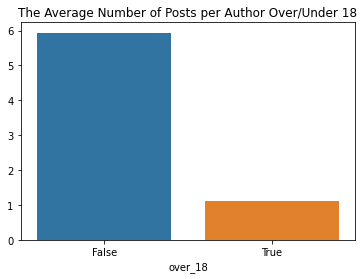

In [ ]:
data.groupby('over_18')['author'].count() / data.groupby('over_18')['author'].nunique()
sns.barplot(x=(data.groupby('over_18')['author'].count() / data.groupby('over_18')['author'].nunique()).index,
            y=(data.groupby('over_18')['author'].count() / data.groupby('over_18')['author'].nunique()).values)
plt.title('The Average Number of Posts per Author Over/Under 18')
plt.show()

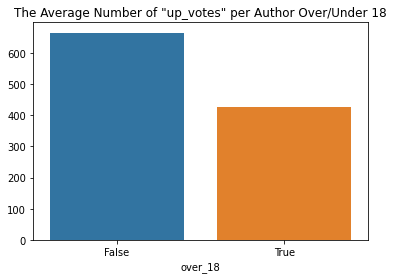

In [ ]:
sns.barplot(x=(data.groupby('over_18')['up_votes'].sum() / data.groupby('over_18')['author'].nunique()).index,
            y=(data.groupby('over_18')['up_votes'].sum() / data.groupby('over_18')['author'].nunique()).values)
plt.title('The Average Number of "up_votes" per Author Over/Under 18')
plt.show()

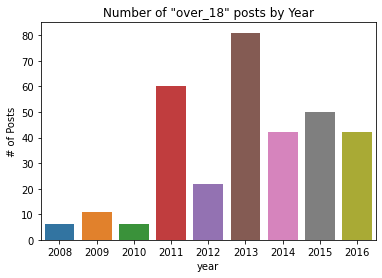

In [ ]:
# analysis of "over_18" posts by year

sns.barplot(x=data.groupby('year')['over_18'].sum().index, y=data.groupby('year')['over_18'].sum().values, ci=None)
plt.title('Number of "over_18" posts by Year')
plt.ylabel("# of Posts")
plt.show()

### Analysis of Contents of "title" Column using TF-IDF Vectors

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

w_tokenizer = WhitespaceTokenizer()
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    text = [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
    text = ' '.join(text)
    return text

title_series = data.title.apply(lemmatize_text)


final_stopwords_list = stopwords.words('english')
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, max_features=200000, 
                                   min_df=0.01, stop_words=final_stopwords_list, 
                                   use_idf=True, ngram_range=(1,2))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
tfidf_X = tfidf_vectorizer.fit_transform(data.title)

In [ ]:
# creating a TfidfVectorizer DataFrame: tfidf_df
tfidf_df = pd.DataFrame(tfidf_X.A, columns=tfidf_vectorizer.get_feature_names())

In [ ]:
tfidf_df.head()

,000,air,al,anti,army,arrested,attack,attacks,bank,bbc,british,calls,children,china,chinese,city,could,country,court,crisis,day,dead,deal,death,egypt,eu,europe,fire,first,forces,foreign,former,found,france,french,gaza,german,germany,government,group,...,old,one,pakistan,palestinian,people,police,president,protest,protests,putin,rebels,report,rights,russia,russian,said,saudi,say,says,security,south,state,syria,syrian,talks,three,time,troops,turkey,two,uk,ukraine,un,us,video,war,women,world,year,years
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.745876,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.606796,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.634488,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.478773,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.569666,0.609644,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.551194,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data[data.over_18==True].index

Int64Index([  1885,   6721,   8414,  12163,  12699,  22288,  22937,  26093,
             35986,  36849,
            ...
            494536, 494947, 499751, 500590, 502531, 503776, 508067, 508176,
            508376, 508706],
           dtype='int64', length=320)

In [ ]:
tf_idf_full_dataset = tfidf_df.sum(axis=0).sort_values(ascending=False)

In [ ]:
tf_idf_over_18_true = tfidf_df.iloc[data[data.over_18==True].index].sum(axis=0).sort_values(ascending=False)

In [ ]:
tf_idf_over_18_false = tfidf_df.iloc[data[data.over_18==False].index].sum(axis=0).sort_values(ascending=False)

In [ ]:
tf_idf_over_18_true

video      36.521545
dead       15.639119
syrian     15.190967
isis       13.179954
death      12.428365
             ...    
israel      0.000000
deal        0.000000
could       0.000000
human       0.000000
foreign     0.000000
Length: 108, dtype: float64

In [ ]:
tf_idf_over_18_false

china            16072.724485
new              13641.610165
us               13577.936043
says             13526.750745
russia           11170.742001
                     ...     
foreign           3321.328022
troops            3299.163672
old               3202.814438
human             3196.865637
islamic state     2556.028153
Length: 108, dtype: float64

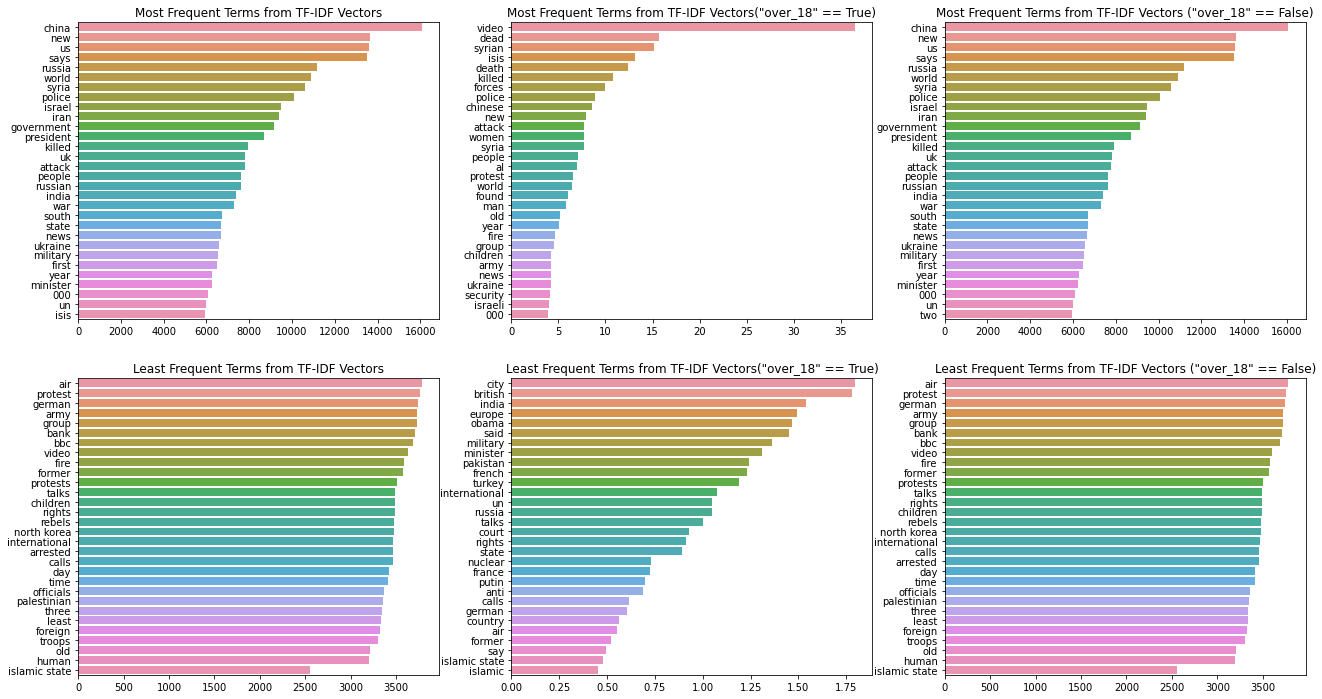

In [ ]:
plt.figure(figsize=(22,12))
plt.subplot(2,3,1)
sns.barplot(y=tf_idf_full_dataset[:30].index,x=tf_idf_full_dataset[:30].values)
plt.title('Most Frequent Terms from TF-IDF Vectors')

plt.subplot(2,3,2)
sns.barplot(y=tf_idf_over_18_true[:30].index,x=tf_idf_over_18_true[:30].values)
plt.title('Most Frequent Terms from TF-IDF Vectors("over_18" == True)')

plt.subplot(2,3,3)
sns.barplot(y=tf_idf_over_18_false[:30].index,x=tf_idf_over_18_false[:30].values)
plt.title('Most Frequent Terms from TF-IDF Vectors ("over_18" == False)')

plt.subplot(2,3,4)
sns.barplot(y=tf_idf_full_dataset[-30:].index,x=tf_idf_full_dataset[-30:].values)
plt.title('Least Frequent Terms from TF-IDF Vectors')

plt.subplot(2,3,5)
# the last twenty values of the this column are null, excluding those entries
sns.barplot(y=tf_idf_over_18_true[-50:-20].index,x=tf_idf_over_18_true[-50:-20].values)
plt.title('Least Frequent Terms from TF-IDF Vectors("over_18" == True)')

plt.subplot(2,3,6)
sns.barplot(y=tf_idf_over_18_false[-30:].index, x=tf_idf_over_18_false[-30:].values)
plt.title('Least Frequent Terms from TF-IDF Vectors ("over_18" == False)')
plt.show()

### Analysis of "title" Feature Grouped By "over_18" Feature
- In the cell below, we can see a them in the over_18 posts contain NSFW/NSFL/Graphic tags. 

- However in analysis of the under 18 posts, there are many that still contain "graphic" tags that not suitable for under 18 users. 

- We will create a new feature "NSFC" (Not-Suitable For Children) that will provide a boolean label for all titles that contain the following words(uncased): "nsfw", "nsfl", "graphic", "kill", "execution" , "decapitation", "rape", "dismember".

(this is by no means an exhaustive list of NSFC terms, but a starting point to be developed depending on future use cases of this model. Business stakeholders would definitively need to consulted on what content is deemed suitable for child audiences, i.e. rape, murder,etc.)

In [ ]:
print('Below are the first ten rows of "titles" filtered by "over_18" posts.\n')
data[data.over_18==True].title.head(10).values

Below are the first ten rows of "titles" filtered by "over_18" posts.



array(['Pics from the Tibetan protests - more graphic than Wikileaks [nsfw? graphic]',
       'MI5 linked to Max Mosley’s Nazi-style, sadomasochistic sex orgy. Mosley’s father led the British Union of Fascists in the 30s and 40s. His mother was a great admirer of Adolf Hitler.[NSFW]',
       'Tabloid Horrifies Germany: Poland s Yellow Press Turns Blood Red (if you follow the link to the gallery: 4th picture is NSFW in the US)',
       'Love Parade Dortmund: Techno Festival Breaks Record with 1.6 Million (with a 90x90 px NSFW thumbnail)',
       'IDF kills young Palestinian boy. Potentially NSFW.',
       'In pictures: Gaza Massacre (Graphic!  possibly NSFW)',
       'In Pictures: the slaughter of Gazan children Victims of the Israeli occupation forces in the tenth day of their attacks on Gaza Strip.  (Graphic!  NSFW?)',
       'Eye-Opening Montage about the Gaza Massacre (NSFW)',
       'NSFW: Taliban Barbers Frequently Sever Customer s Heads ',
       'Famous Russian Female Body Guard

In [ ]:
data[data.title.str.contains(pat='nsfl', case=False)]['over_18'].value_counts()

True    26
Name: over_18, dtype: int64

In [ ]:
data[data.title.str.contains(pat='nsfw', case=False)]['over_18'].value_counts()

True    127
Name: over_18, dtype: int64

In [ ]:
data[data.title.str.contains(pat='graphic', case=False)]['over_18'].value_counts()

False    555
True      28
Name: over_18, dtype: int64

In [ ]:
data[data.title.str.contains(pat='dismember', case=False)]['over_18'].value_counts()

False    65
Name: over_18, dtype: int64

In [ ]:
data[data.title.str.contains(pat='murder', case=False)]['over_18'].value_counts()

False    4262
True        6
Name: over_18, dtype: int64

In [ ]:
# creating new feature "NSFC" (Not Suitable For Children)

data['nsfc'] = data.title.str.contains(pat='nsfw|nsfl|graphic|kill|dismember|kill|decapitation|execution|murder|rape', case=False)

In [ ]:
data.nsfc.value_counts()

False    471608
True      37628
Name: nsfc, dtype: int64

## Analysis of "word_count"/"char_count" Features from "title" Column

In the cells below, we will analyze the word count and character count per posting. Both distributions are right skewed with many outliers with high word/character counts, causing for a high standard deviation.

In [ ]:
#First we will create some additional columns to further analyze the contents of the "title" column
data['char_count'] = data.title.apply(lambda x: len(x))
data['word_count'] = data.title.apply(lambda x: len(x.split()))

In [ ]:
data.head(2)

,time_created,up_votes,title,over_18,author,clock_time,hour,day_of_week,month,year,hour_period,season,nsfc,char_count,word_count
0,2008-01-25 03:34:06,3,Scores killed in Pakistan clashes,False,polar,03:34:06,3,4,1,2008,Late_Night,Q1,True,33,5
1,2008-01-25 03:34:35,2,Japan resumes refuelling mission,False,polar,03:34:35,3,4,1,2008,Late_Night,Q1,False,32,4


In [ ]:
data.char_count.describe()

count    509236.000000
mean         89.446082
std          59.701217
min           1.000000
25%          52.000000
50%          66.000000
75%         100.000000
max         320.000000
Name: char_count, dtype: float64

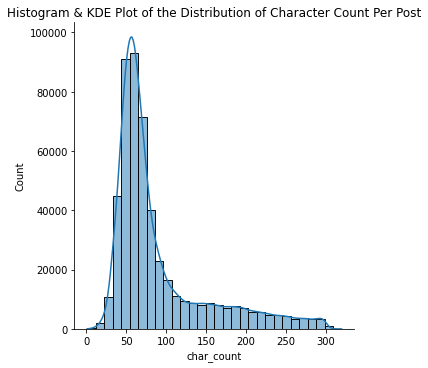

In [ ]:
sns.displot(data.char_count, bins=30, kde=True)
plt.title("Histogram & KDE Plot of the Distribution of Character Count Per Post")
plt.show()

In [ ]:
data.word_count.describe()

count    509236.000000
mean         14.439048
std           9.881765
min           1.000000
25%           8.000000
50%          11.000000
75%          16.000000
max          64.000000
Name: word_count, dtype: float64

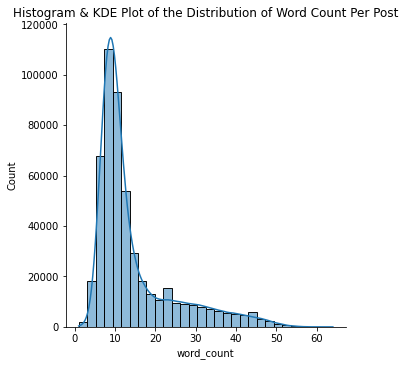

In [ ]:
sns.displot(data.word_count, bins=30, kde=True)
plt.title("Histogram & KDE Plot of the Distribution of Word Count Per Post")
plt.show()

## Adding Flesch-Kincaid Grade Level and Flesch Readability Score
For these features we will use the [textstat](https://pypi.org/project/textstat/) library.

In [ ]:
data['flesch_readability'] = data.title.apply(lambda x: flesch_reading_ease(x))
data['flesch_grade'] = data.title.apply(lambda x: flesch_kincaid_grade(x))

     |████████████████████████████████| 102kB 3.3MB/s 
     |████████████████████████████████| 1.9MB 26.6MB/s 


# Analysis of "up_votes" Column

In the cell below we again see a right skewed distribution with many outliers of "up_votes", with the medain with 5 "up_votes", 75% percentile with 16, but with a mean of 112 "up_votes".

In [ ]:
data.up_votes.describe()

count    509236.000000
mean        112.236283
std         541.694675
min           0.000000
25%           1.000000
50%           5.000000
75%          16.000000
max       21253.000000
Name: up_votes, dtype: float64

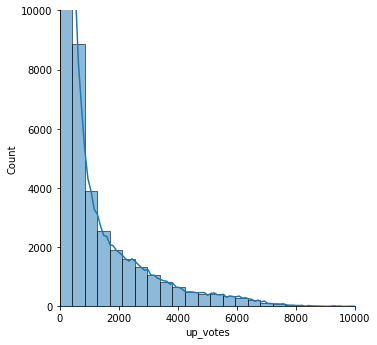

In [ ]:
sns.displot(x=data.up_votes,bins=50, kde=True)
plt.xlim((0,10000))
plt.ylim((0,10000))
plt.show()

In [ ]:
cumulative_up_votes_by_author = data.groupby('author')['up_votes'].sum().sort_values(ascending=False)
cumulative_up_votes_by_author

author
maxwellhill      1985416
anutensil        1531544
Libertatea        832102
DoremusJessup     584380
Wagamaga          580121
                  ...   
dingdong99             0
dinkstar               0
dinkydarko             0
dinram1                0
zzzcott                0
Name: up_votes, Length: 85838, dtype: int64

In [ ]:
cumulative_up_votes_by_author.describe()

count    8.583800e+04
mean     6.658445e+02
std      1.085183e+04
min      0.000000e+00
25%      2.000000e+00
50%      9.000000e+00
75%      6.200000e+01
max      1.985416e+06
Name: up_votes, dtype: float64

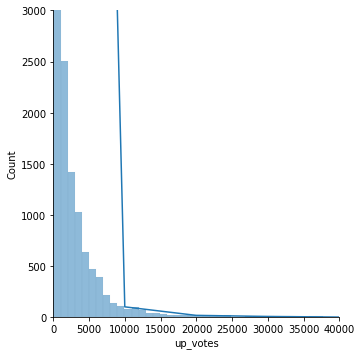

In [ ]:
sns.displot(x=cumulative_up_votes_by_author,bins=2000, kde=True)
plt.xlim((0,40000))
plt.ylim((0,3000))
plt.show()

## Analysis of Time & Date Variables
- In the 2x2 plot analyzing the proportion of posts by the time of day, there is not a significant difference between weekdays and weekends. 
- However, in comparing the average number of posts on weekdays vs weekends, there is a much higher volume weekdays.
- Analyzing the volume of posts by "hour", we see a higher volume between 10am and midnight, with peak traffic between 3pm-9pm.

In [ ]:
data.head()

,time_created,up_votes,title,over_18,author,clock_time,hour,day_of_week,month,year,hour_period,season,nsfc,char_count,word_count,flesch_readability,flesch_grade
0,2008-01-25 03:34:06,3,Scores killed in Pakistan clashes,False,polar,03:34:06,3,4,1,2008,Late_Night,Q1,True,33,5,83.32,2.9
1,2008-01-25 03:34:35,2,Japan resumes refuelling mission,False,polar,03:34:35,3,4,1,2008,Late_Night,Q1,False,32,4,33.58,9.6
2,2008-01-25 03:42:03,3,US presses Egypt on Gaza border,False,polar,03:42:03,3,4,1,2008,Late_Night,Q1,False,31,6,90.77,2.1
3,2008-01-25 03:54:50,1,Jump-start economy: Give health care to all,False,fadi420,03:54:50,3,4,1,2008,Late_Night,Q1,False,44,7,64.37,6.0
4,2008-01-25 15:25:20,4,Council of Europe bashes EU&UN terror blacklist,False,mhermans,15:25:20,15,4,1,2008,Noon,Q1,False,47,7,38.99,9.6


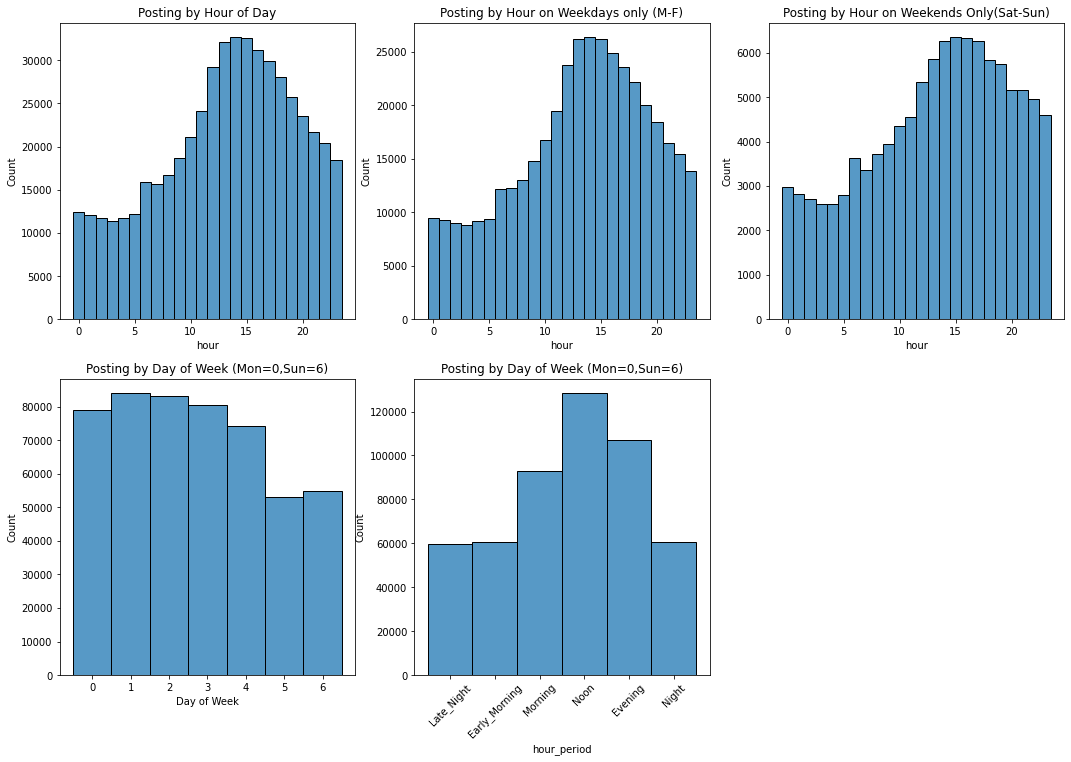

In [ ]:
plt.figure(figsize=(18,12))
plt.subplot(2,3,1) 
sns.histplot(data.hour, discrete=True)
plt.title('Posting by Hour of Day')
plt.subplot(2,3,2) 
sns.histplot(data[data.time_created.dt.dayofweek < 5].hour, discrete=True)
plt.title('Posting by Hour on Weekdays only (M-F)')
plt.subplot(2,3,3) 
sns.histplot(data[data.time_created.dt.dayofweek >= 5].hour, discrete=True)
plt.title('Posting by Hour on Weekends Only(Sat-Sun)')
plt.subplot(2,3,4) 
sns.histplot(data.time_created.dt.dayofweek, discrete=True)
plt.title('Posting by Day of Week (Mon=0,Sun=6)')
plt.xlabel('Day of Week')
plt.subplot(2,3,5) 
sns.histplot(data['hour_period'], discrete=True)
plt.title('Posting by Day of Week (Mon=0,Sun=6)')
plt.xticks(rotation=45)
plt.show()



In the plots below:
- There is not a significant difference in posts by the day of the month ( the 31st day of the month has less posts, but that is only because not all months have 31 days.
- Looking at Posts by Month, there does seem to be a trend of less posts between November and February, at this time there is not an attributable reason for this trend.
- Looking at the Posts by Year, there has been icreasing posting since 2008, with a large jump in 2013, however there is a downward trend in 2016 (however this could be attributed to the fact that the most recently data from that year was 11/22, and the entire years data had not been collected yet)
- Analyzing the Posts By Month Grouped by Year plot, there is not discernable trend trough the years, and the increasing/decreasing usage by month appears on first analysis random (if this was of significance to a particular business consideration (seasonality for example, addition Hypothesis Testing could be done to term if there is any statistical significance in the these months shifts throughout the year)

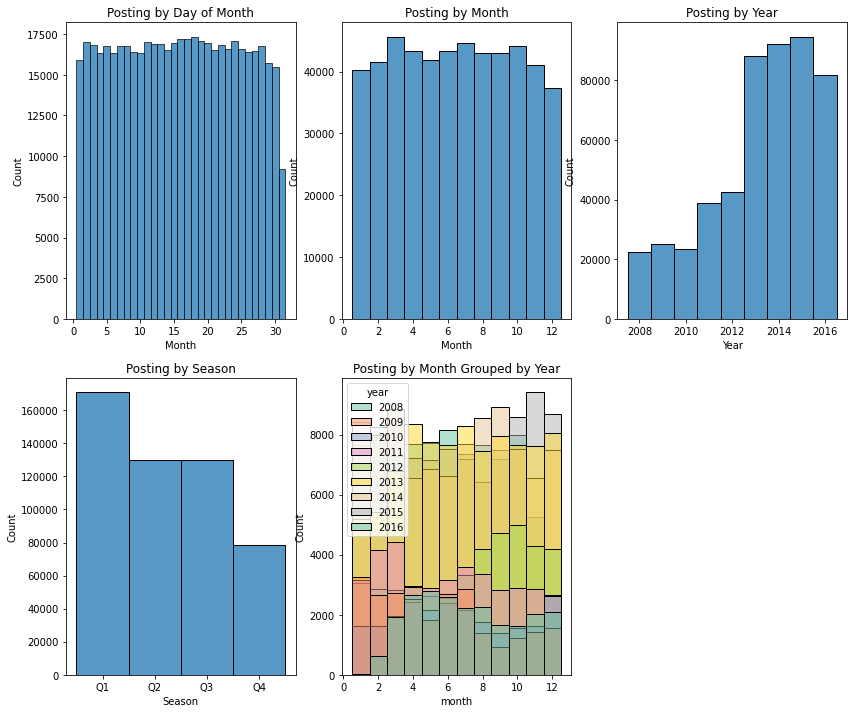

In [ ]:
plt.figure(figsize=(14,12))
plt.subplot(2,3,1) 
sns.histplot(data.time_created.dt.day, discrete=True)
plt.title('Posting by Day of Month')
plt.xlabel('Month')

plt.subplot(2,3,2) 
sns.histplot(data.time_created.dt.month, discrete=True)
plt.title('Posting by Month')
plt.xlabel('Month')

plt.subplot(2,3,3) 
sns.histplot(data.time_created.dt.year, discrete=True)
plt.title('Posting by Year')
plt.xlabel('Year')

plt.subplot(2,3,4) 
sns.histplot(data.season, discrete=True)
plt.title('Posting by Season')
plt.xlabel('Season')

plt.subplot(2,3,5) 
sns.histplot(data = data, x='month', hue= 'year', discrete=True, palette='Set2')
plt.title('Posting by Month Grouped by Year')

plt.show()

## Analsyis of Correlation Matrix & Pairplots
In analzying the heatmap/correlation matrix below, most of the variables show little correlation amongst each other, except for "word_count"/"char_count" and "flesch_grade"/"flesch_readability". There two pairs of variables show such a high level of colinearity that we will drop one from each pair before modeling.


<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


<Figure size 1080x1080 with 0 Axes>

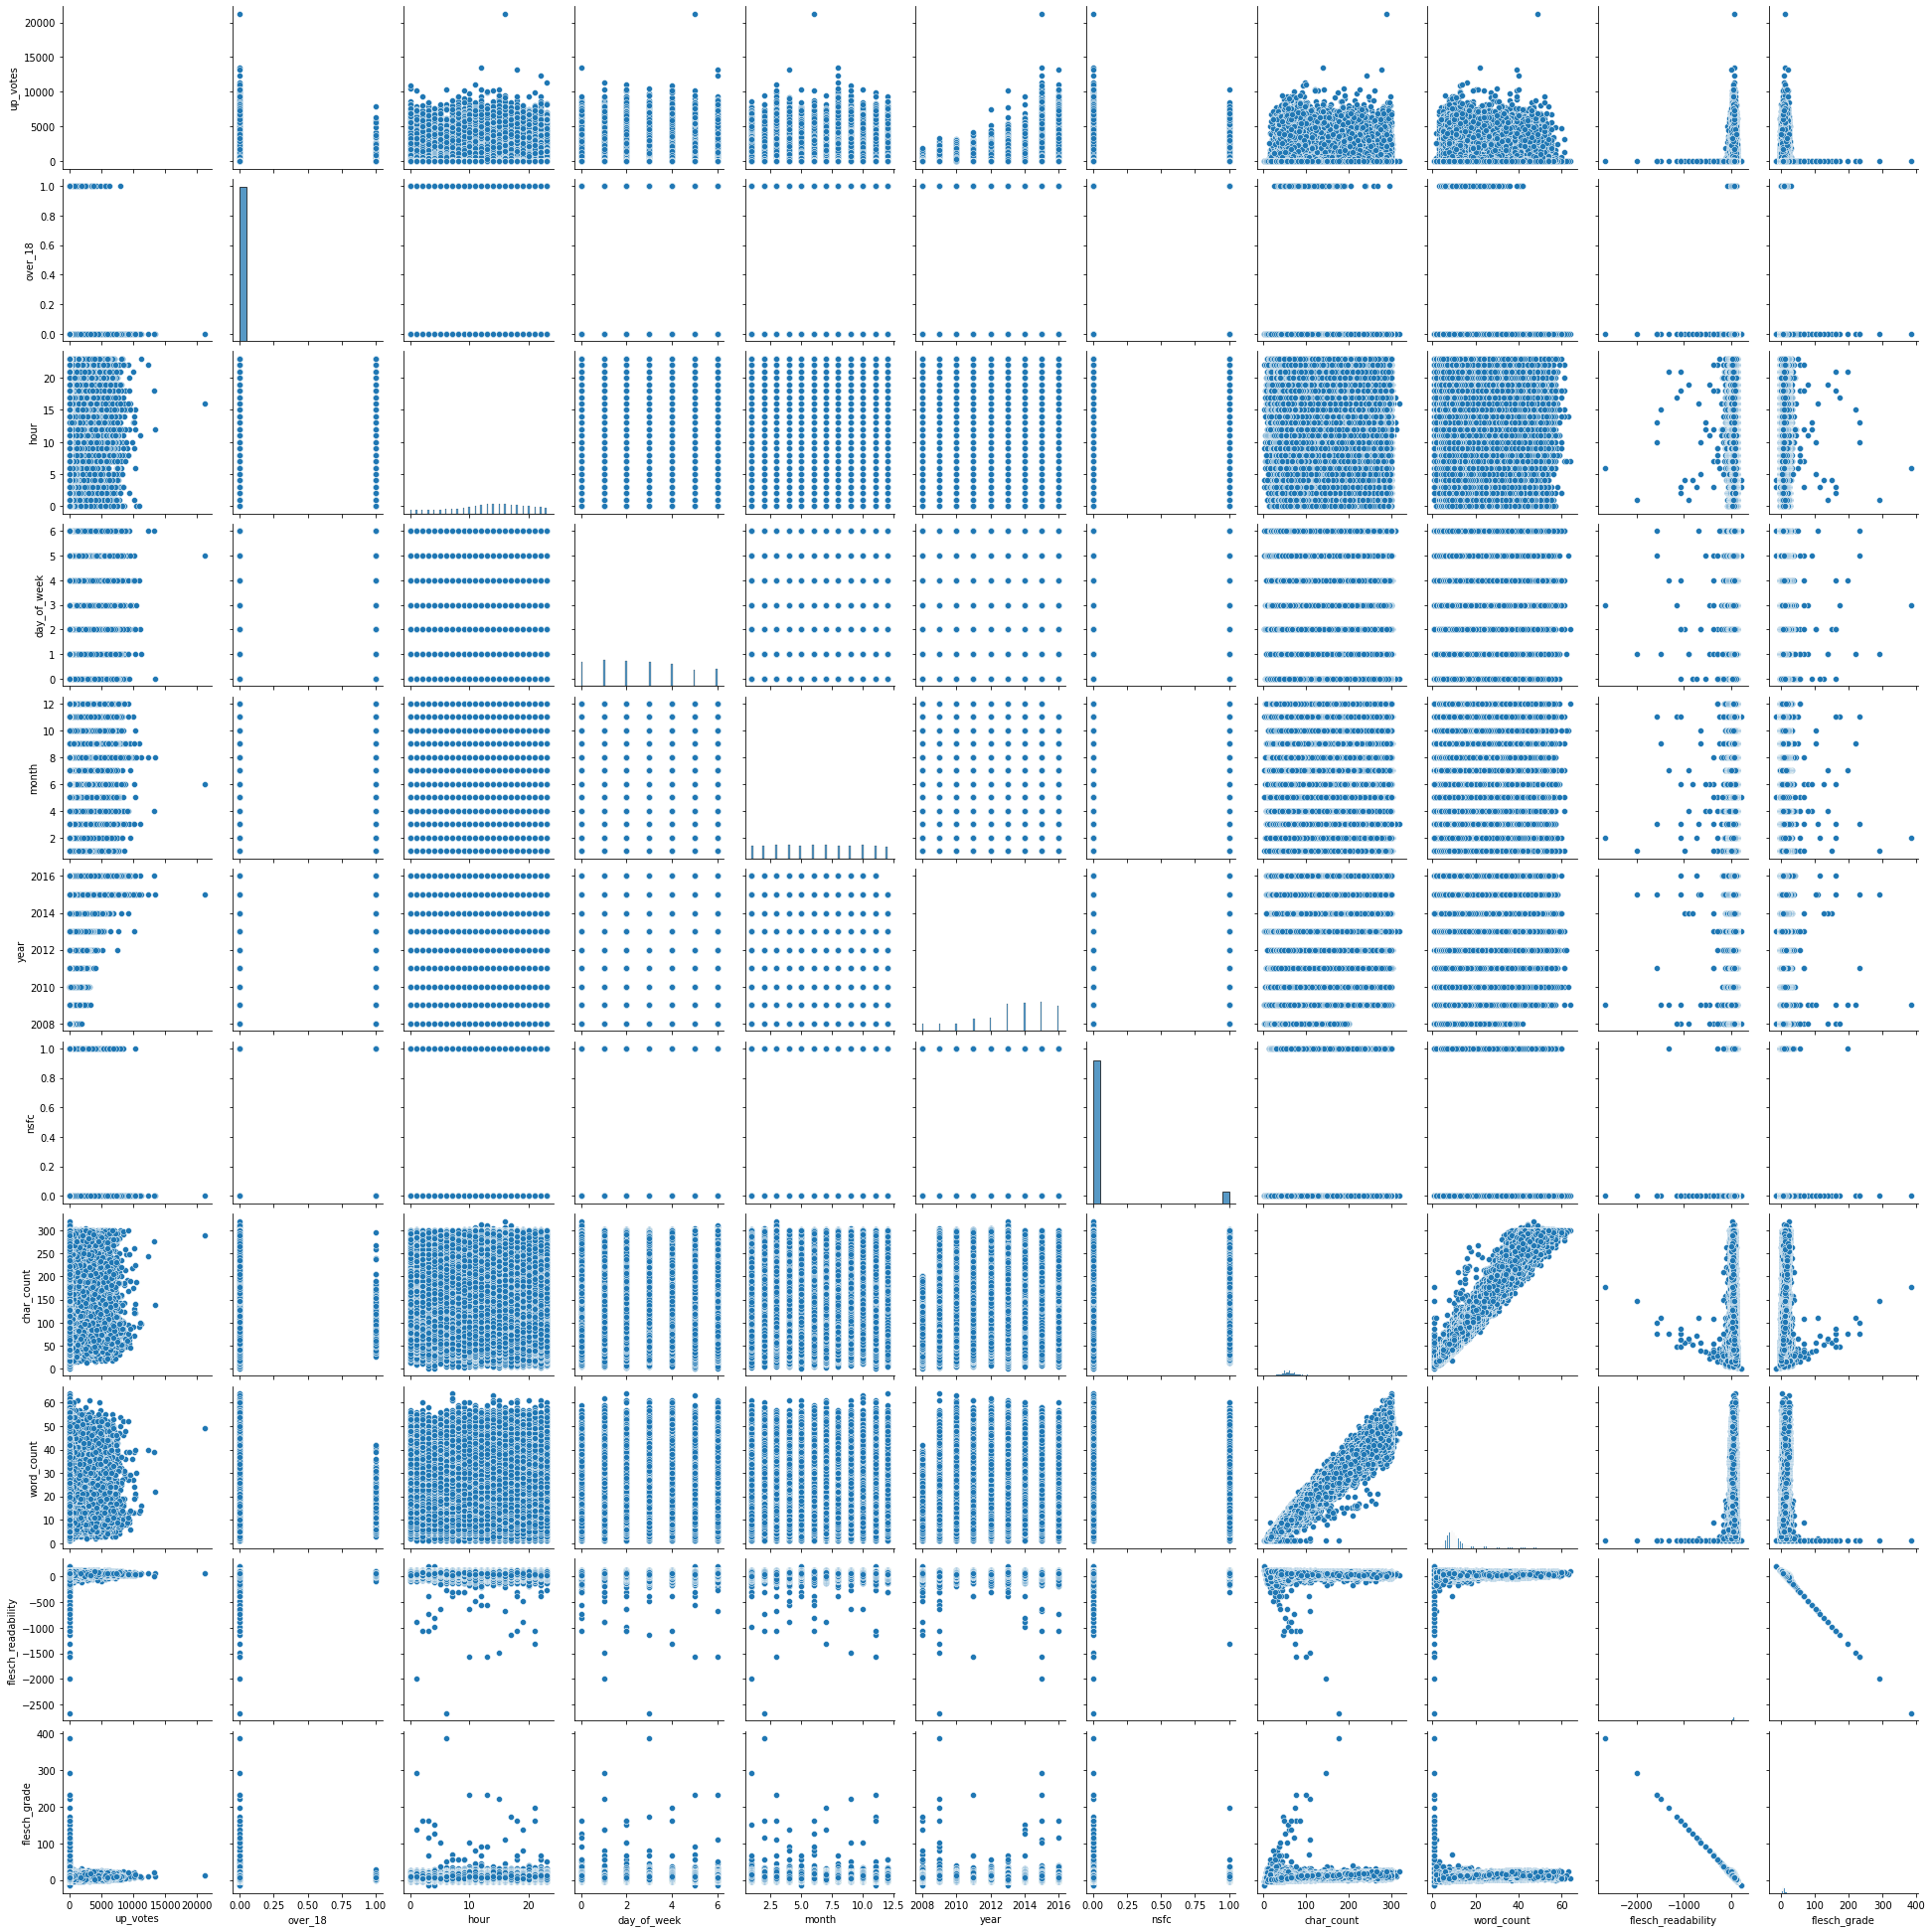

In [ ]:
plt.figure(figsize=(15,15))
sns.pairplot(data)
plt.show()

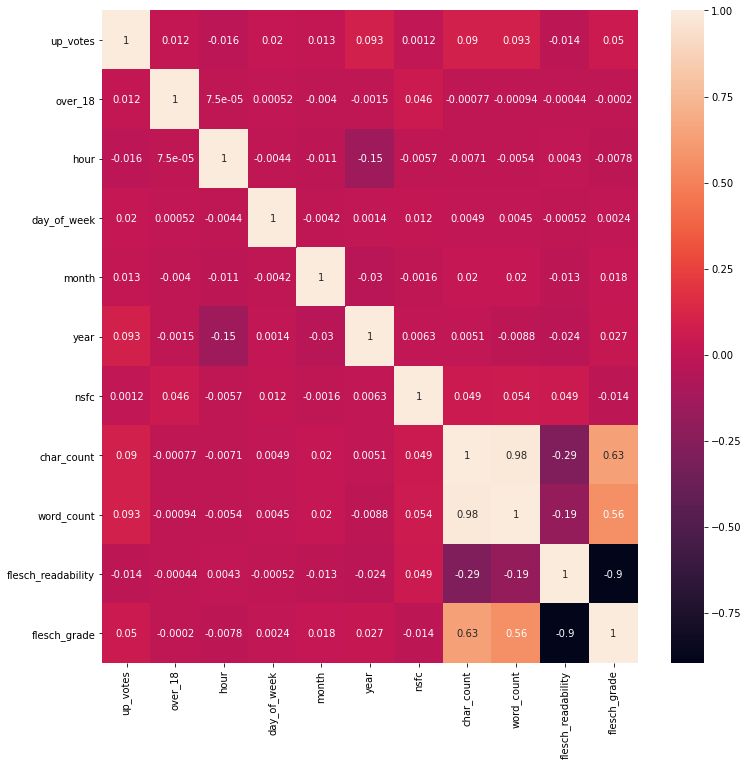

In [ ]:
plt.figure(figsize=(12,12))
sns.heatmap(data.corr(), annot=True)
plt.show()

Hour and Year show the next highest rate of correlation, but in visually analyzing the plot below, there is clearly a trend over the years that demonstrates peak posting between 11am-8pm, but not to degree of colinearity that would merit pruning either of these features.

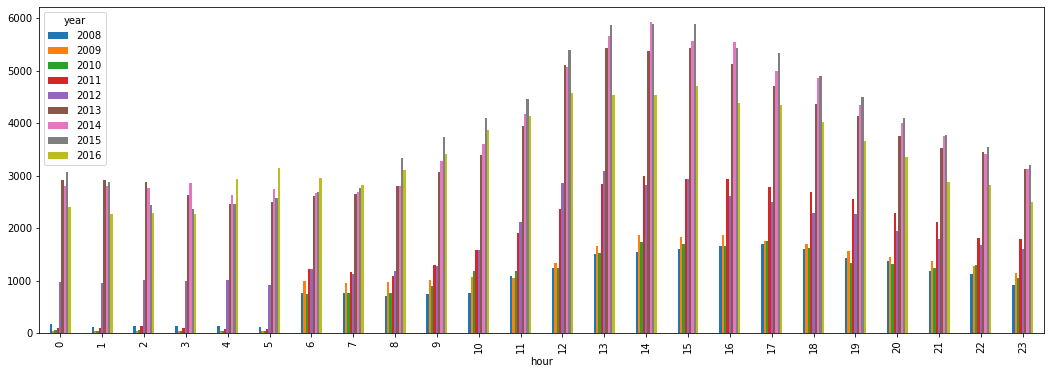

In [ ]:
data.groupby('hour')['year'].value_counts().sort_values().unstack().plot.bar(figsize=(18,6))
plt.show()
          

# End of Data Wrangling and EDA 
In the next two notebooks we will begin feature engineering and the modeling process.

In [ ]:
data.to_csv('Eluvio_DS_Challenge_cleaned_wrangled.csv')

In [ ]:
data.head()

,time_created,up_votes,title,over_18,author,clock_time,hour,day_of_week,month,year,hour_period,season,nsfc,char_count,word_count,flesch_readability,flesch_grade
0,2008-01-25 03:34:06,3,Scores killed in Pakistan clashes,False,polar,03:34:06,3,4,1,2008,Late_Night,Q1,True,33,5,83.32,2.9
1,2008-01-25 03:34:35,2,Japan resumes refuelling mission,False,polar,03:34:35,3,4,1,2008,Late_Night,Q1,False,32,4,33.58,9.6
2,2008-01-25 03:42:03,3,US presses Egypt on Gaza border,False,polar,03:42:03,3,4,1,2008,Late_Night,Q1,False,31,6,90.77,2.1
3,2008-01-25 03:54:50,1,Jump-start economy: Give health care to all,False,fadi420,03:54:50,3,4,1,2008,Late_Night,Q1,False,44,7,64.37,6.0
4,2008-01-25 15:25:20,4,Council of Europe bashes EU&UN terror blacklist,False,mhermans,15:25:20,15,4,1,2008,Noon,Q1,False,47,7,38.99,9.6
